# spoken_digit

https://www.tensorflow.org/datasets/catalog/spoken_digit

The code is mainly based on https://www.tensorflow.org/tutorials/audio/simple_audio

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

keras = tf.keras
tf.__version__

'2.5.0'

# Prepare the Data

In [2]:
# pip install pydub
(train_ds, valid_ds, test_ds), info = tfds.load(
    'spoken_digit', 
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True, 
    as_supervised = True)
info

tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the beginnings and ends.
    
    5 speakers
    2,500 recordings (50 of each digit per speaker)
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_path='/Users/zhengjiaxun/tensorflow_datasets/spoken_digit/1.0.9',
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=tf.int64),
        'audio/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    sup

In [3]:
class_names = info.features['label'].names
print(class_names)
print(info.features['label'].num_classes)
print(info.splits['train'].num_examples)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
10
2500


In [4]:
for audio, label in train_ds.take(1):
    print(audio)
    print(label)
    print(class_names[label])

tf.Tensor([   0    0 -256 ... -512 -256 -512], shape=(1525,), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
2


In [5]:
tfds.as_dataframe(train_ds.take(5), info)

audio  label
0  [0, 0, -256, 0, -256, 0, -256, 0, 0, 0, 0, 0, ...      2
1  [0, 0, 0, 0, -256, 0, -256, 0, -256, 0, -256, ...      1
2  [-10, -6, -25, -20, -17, -24, -26, -30, -30, -...      9
3  [0, 2, -3, -2, -2, -6, -1, -6, -8, -6, -8, -12...      9
4  [-256, 0, -256, 0, 0, -256, -256, 0, -512, 0, ...      7

In [6]:
TOTAL_LENGTH = 9000

(1525,)


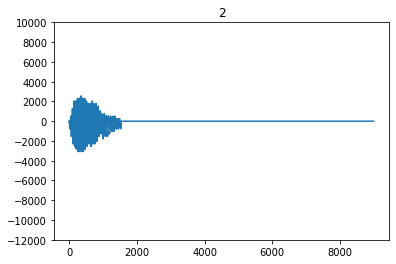

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_waveform(ax, waveform, label = None, total_length = TOTAL_LENGTH, verbose = False):
    padded = tf.concat([waveform, [0] * (9000 - np.size(waveform))], axis = 0)
    ax.plot(padded.numpy())
    ax.set_yticks(np.arange(-12000, 12000, 2000))
    if verbose:
        print(waveform.shape)
    if label is not None:
        ax.set_title(class_names[label.numpy()])
    
for audio, label in train_ds.take(1):
    ax = plt.axes()
    plot_waveform(ax, audio, label = label, verbose = True)

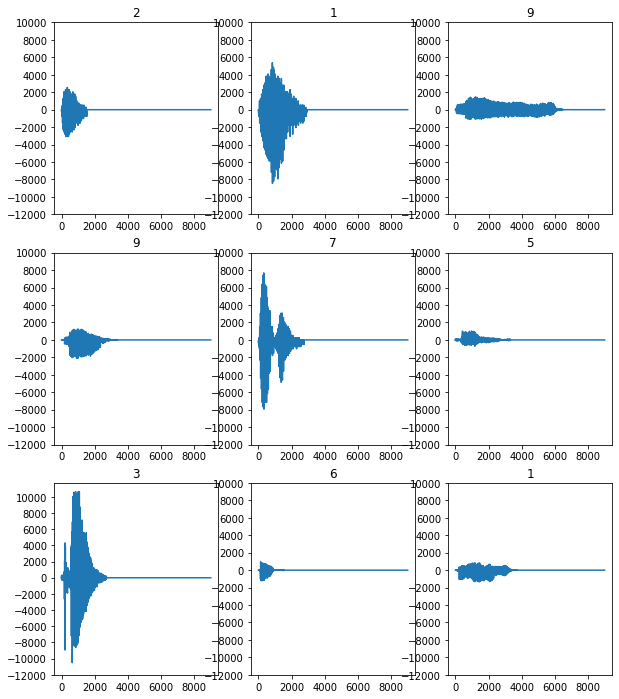

In [8]:
nrow, ncol = 3, 3
total = nrow * ncol

fig, axes = plt.subplots(nrow, ncol, figsize = (10, 12))
for i, (audio, label) in enumerate(train_ds.take(total)):
    r, c = i // 3, i % 3
    ax = axes[r][c]
    plot_waveform(ax, audio, label)

## Convert Waveform to Spectrogram

In [9]:
len(next(iter(train_ds))[0])

1525

In [10]:
# https://stackoverflow.com/questions/49626782/typeerror-lambda-missing-1-required-positional-argument-w
# We cannot call the parameter as tuple
list(map(lambda waveform_label: len(waveform_label[0]), [next(iter(train_ds))]))

[1525]

In [11]:
lengths = list(
    map(lambda waveform_label_pair: len(waveform_label_pair[0]), train_ds.as_numpy_iterator())
)
print(min(lengths), max(lengths))

1288 8281


In [12]:
def get_spectrogram(waveform, total_length = TOTAL_LENGTH, verbose = False):
    if verbose:
        print(len(waveform))
    waveform = tf.cast(waveform, tf.float32)
    # TODO: should we pad two ends?
    if len(waveform) < total_length:
        zero_padding = tf.zeros([total_length] - tf.shape(waveform), dtype = tf.float32)
        resized = tf.concat([waveform, zero_padding], 0)
    else:
        resized = waveform[:total_length]
    # padded = tf.concat([zero_padding, waveform], 0)
    # https://www.tensorflow.org/api_docs/python/tf/signal/stft
    spectorgram = tf.signal.stft(
        resized,
        frame_length = 255,
        frame_step = 128,
    )
    if verbose:
        print(spectorgram.shape)
    return tf.abs(spectorgram)
    
for waveform, _ in train_ds.take(1):
    print(get_spectrogram(waveform, verbose = True))

1525
(69, 129)
tf.Tensor(
[[27831.783   13385.691    2025.001   ...  1299.3816    728.5834
     48.29883]
 [29694.773   15497.726     770.877   ...  2986.8875    326.95264
   1435.5938 ]
 [28181.756   13774.739    1131.7078  ...   883.14734  1720.924
    731.37695]
 ...
 [    0.          0.          0.      ...     0.          0.
      0.     ]
 [    0.          0.          0.      ...     0.          0.
      0.     ]
 [    0.          0.          0.      ...     0.          0.
      0.     ]], shape=(69, 129), dtype=float32)


width: 69 - height: 129
69 129
(129, 69)


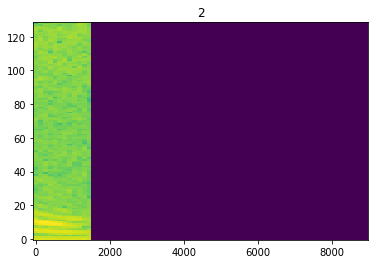

In [13]:
def plot_spectrogram(ax, spectrogram, label = None, verbose = False):
    log_spec = np.log(0.000001 + spectrogram.numpy().T)
    height, width = log_spec.shape[0], log_spec.shape[1]
    if verbose:
        print(f'width: {width} - height: {height}')
    X = np.linspace(0, np.size(spectrogram), num = width, dtype = int)
    Y = range(height)
    if verbose:
        print(len(X), len(Y))
        print(log_spec.shape)
    ax.pcolormesh(X, Y, log_spec, shading = 'auto')
    if label is not None:
        ax.set_title(class_names[label.numpy()])
    
for waveform, label in train_ds.take(1):
    ax = plt.axes()
    spectrogram = get_spectrogram(waveform)
    plot_spectrogram(ax, spectrogram, label, verbose = True)

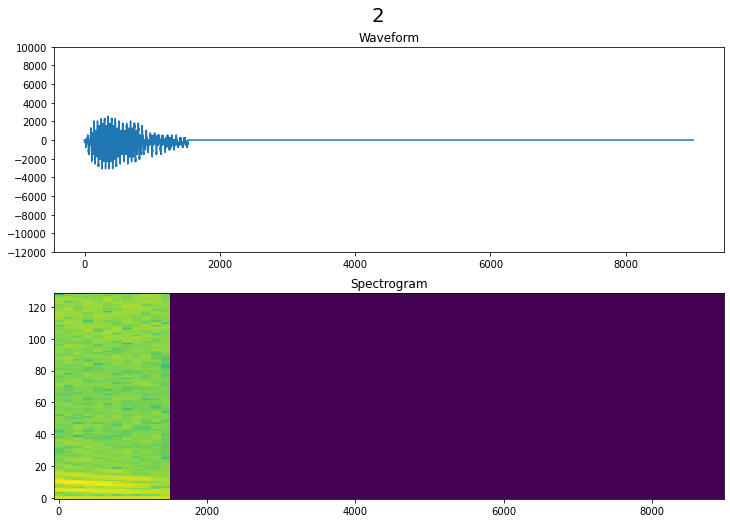

In [14]:
# https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot
def plot_waveform_and_spectrogram(waveform, label):
    fig, axes = plt.subplots(2, figsize = (12, 8))
    fig.subplots_adjust(top=0.91)
    fig.suptitle(class_names[label], fontsize = 20)
    axes[0].set_title('Waveform')
    plot_waveform(axes[0], waveform)
    
    axes[1].set_title('Spectrogram')
    spectrogram = get_spectrogram(waveform)
    plot_spectrogram(axes[1], spectrogram)
    
for waveform, label in train_ds.take(1):
    plot_waveform_and_spectrogram(waveform, label)
    

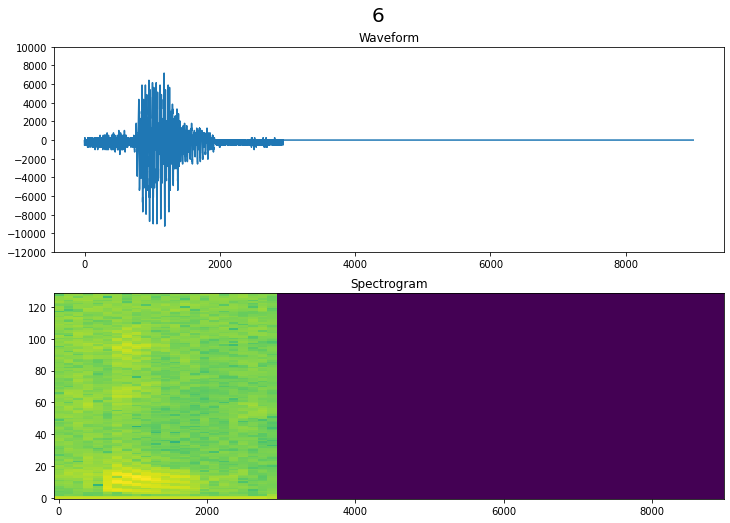

In [15]:
for waveform, label in valid_ds.take(1):
    plot_waveform_and_spectrogram(waveform, label)

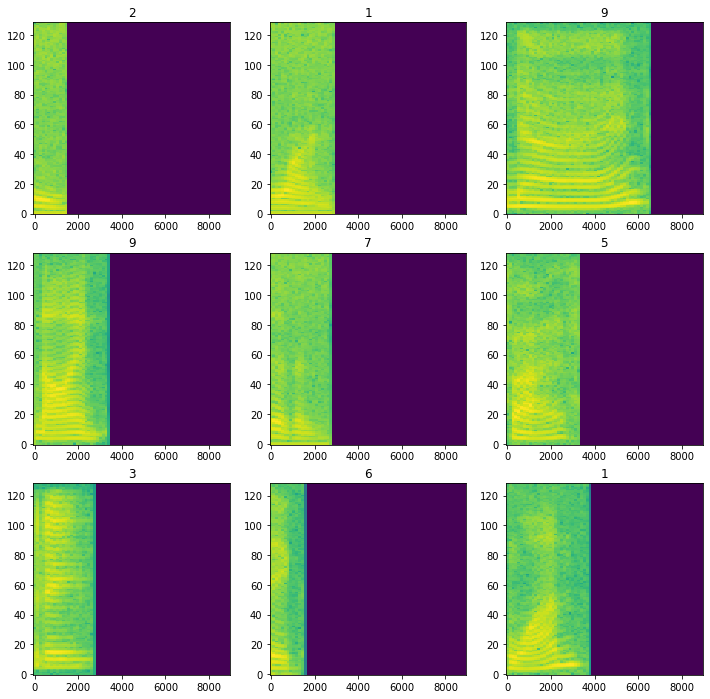

In [16]:
nrow, ncol = 3, 3
total = nrow * ncol

fig, axes = plt.subplots(nrow, ncol, figsize = (12, 12))
for i, (audio, label) in enumerate(train_ds.take(total)):
    r, c = i // 3, i % 3
    ax = axes[r][c]
    plot_spectrogram(ax, get_spectrogram(audio), label)

In [17]:
# TODO: reference code 
#   get_spectrogram_and_label_id
#   tf.expand_dims(get_spectrogram(waveform), -1)
def create_batch_dataset(ds, batch_size = 128, is_train = False):
    ds = ds.map(
        lambda waveform, label: (get_spectrogram(waveform), label),
        num_parallel_calls = tf.data.AUTOTUNE
    )
    ds = ds.cache()
    if is_train:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_batch_ds = create_batch_dataset(train_ds, is_train = True)
valid_batch_ds = create_batch_dataset(valid_ds)
test_batch_ds = create_batch_dataset(test_ds)

In [18]:
sample = next(iter(train_ds))
print(sample)
sample_batch = next(iter(train_batch_ds))
print(sample_batch[0].shape)
input_shape = sample_batch[0].shape[1:]
print(input_shape)

(<tf.Tensor: shape=(1525,), dtype=int64, numpy=array([   0,    0, -256, ..., -512, -256, -512])>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
(128, 69, 129)
(69, 129)


# Build and Train Model

In [50]:
import pandas as pd

def plot_item(history_df, colname = 'loss', f = np.min, ax = None):
    val_colname = f'val_{colname}'
    print(f'{colname}: {f(history_df[colname]):.4f} - {val_colname}: {f(history_df[val_colname]):.4f}')
    history_df.loc[:, [colname, val_colname]].plot(title = colname.capitalize() , ax = ax)

def show_history(history):
    history_df = pd.DataFrame(history.history)
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
    plot_item(history_df, ax = axes[0])
    plot_item(history_df, 'accuracy', f = np.max, ax = axes[1])    

In [20]:
def build_and_fit_model(model, epochs = 500):
    model.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        optimizer = 'adam',
        metrics = ['accuracy'],
    )
    
    early_stopping = keras.callbacks.EarlyStopping(
        patience = 5, restore_best_weights = True, verbose = 1
    )
    
    history = model.fit(
        train_batch_ds,
        epochs = epochs,
        validation_data = valid_batch_ds,
        callbacks = [early_stopping],
    )
    return history

In [21]:
# Since train_batch_ds would shuffle the sequence, we use validation as a sample
sample_spectrom = next(iter(valid_batch_ds))[0]
sample_spectrom[0]

<tf.Tensor: shape=(69, 129), dtype=float32, numpy=
array([[30082.906  , 15256.2295 ,   711.74994, ...,  2749.2073 ,
          385.63535,   384.4248 ],
       [30385.69   , 15545.524  ,  1410.879  , ...,  4907.364  ,
         2979.4673 ,  3499.295  ],
       [30842.479  , 16132.788  ,  1325.7776 , ...,   980.9802 ,
         3173.3442 ,  3537.7363 ],
       ...,
       [    0.     ,     0.     ,     0.     , ...,     0.     ,
            0.     ,     0.     ],
       [    0.     ,     0.     ,     0.     , ...,     0.     ,
            0.     ,     0.     ],
       [    0.     ,     0.     ,     0.     , ...,     0.     ,
            0.     ,     0.     ]], dtype=float32)>

## Adapt Normalization Layer

In [22]:
normalization_layer = keras.layers.experimental.preprocessing.Normalization()
normalization_layer.adapt(train_batch_ds.map(lambda spectrogram, _: spectrogram))

In [23]:
normalization_layer([sample_spectrom[0]])

<tf.Tensor: shape=(1, 69, 129), dtype=float32, numpy=
array([[[ 3.9082942 ,  3.8547401 , -0.02161221, ...,  3.1117861 ,
          0.20859373,  0.23805483],
        [ 3.9503036 ,  3.9333158 ,  0.27255696, ...,  5.76873   ,
          3.477329  ,  4.206955  ],
        [ 4.013681  ,  4.092823  ,  0.23674923, ...,  0.93489116,
          3.7216518 ,  4.255936  ],
        ...,
        [-0.26554808, -0.28901517, -0.3210918 , ..., -0.27281058,
         -0.27738217, -0.25177094],
        [-0.26554808, -0.28901517, -0.3210918 , ..., -0.27281058,
         -0.27738217, -0.25177094],
        [-0.26554808, -0.28901517, -0.3210918 , ..., -0.27281058,
         -0.27738217, -0.25177094]]], dtype=float32)>

In [24]:
print(sample_spectrom[0][0].shape)
var = (30385.69 - 30082.906)/( 3.9503381 - 3.9083283 )
print(var)
mean = 30082.906 - 3.9083283 * var
print(mean)

(129,)
7207.461116215696
1913.7817483446051


In [25]:
print(len(normalization_layer.get_weights()))
for i in range(len(normalization_layer.get_weights())):
    print(normalization_layer.get_weights()[i].shape)

3
(129,)
(129,)
()


In [26]:
# Shuffle version should not make these values alter
print(normalization_layer.get_weights()[0].shape)
mean = normalization_layer.get_weights()[0][0]
print(normalization_layer.get_weights()[1].shape)
var = normalization_layer.get_weights()[1][0]
print(mean)
print(var)
print(sample_spectrom[0][0][0].numpy())
(30082.906 - mean)/(tf.math.sqrt(var))

(129,)
(129,)
1913.9338
51947850.0
30082.906


<tf.Tensor: shape=(), dtype=float32, numpy=3.9082942>

## Build Model

In [47]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = input_shape),
#    keras.layers.experimental.preprocessing.Resizing(32, 32),
    normalization_layer,
    # We add one lambda layer to expand dims, since cov layer take 1 channel dim at last
    keras.layers.Lambda(
        # First df lambda is for batch
        # tf.map_fn is for eager execution (map is not allowed)
        lambda df: tf.map_fn(lambda x: tf.expand_dims(x, -1) , df)
    ),
#    keras.layers.Reshape()
    keras.layers.Conv2D(32, 3, activation = 'relu'),
    keras.layers.Conv2D(64, 3, activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, 3, activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, 3, activation = 'relu'),
    keras.layers.Flatten(),
#    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(16),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(class_names)),
])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 69, 129)           259       
_________________________________________________________________
lambda_10 (Lambda)           (None, 69, 129, 1)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 67, 127, 32)       320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 65, 125, 64)       18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 62, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 62, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 30, 60, 64)      

In [48]:
history = build_and_fit_model(model)

Epoch 1/500
16/16 [==============================] - 17s 1s/step - loss: 1.9778 - accuracy: 0.3205 - val_loss: 1.5769 - val_accuracy: 0.5880
Epoch 2/500
16/16 [==============================] - 16s 1s/step - loss: 1.3657 - accuracy: 0.5905 - val_loss: 1.1907 - val_accuracy: 0.6760
Epoch 3/500
16/16 [==============================] - 16s 1s/step - loss: 1.0856 - accuracy: 0.7005 - val_loss: 0.9276 - val_accuracy: 0.7760
Epoch 4/500
16/16 [==============================] - 16s 1s/step - loss: 0.8664 - accuracy: 0.7495 - val_loss: 0.7619 - val_accuracy: 0.8120
Epoch 5/500
16/16 [==============================] - 16s 1s/step - loss: 0.6824 - accuracy: 0.8065 - val_loss: 0.4841 - val_accuracy: 0.8840
Epoch 6/500
16/16 [==============================] - 16s 997ms/step - loss: 0.4910 - accuracy: 0.8510 - val_loss: 0.3689 - val_accuracy: 0.9000
Epoch 7/500
16/16 [==============================] - 16s 1s/step - loss: 0.4429 - accuracy: 0.8615 - val_loss: 0.3375 - val_accuracy: 0.9320
Epoch 8/50

loss: 0.0448 - val_loss: 0.1082
accuracy: 0.9860 - val_accuracy: 0.9760


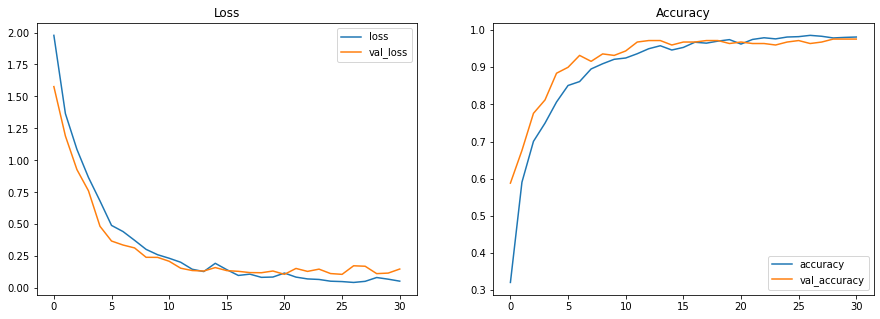

In [51]:
show_history(history)

In [52]:
model.evaluate(test_batch_ds)

2/2 [==============================] - 1s 191ms/step - loss: 0.1221 - accuracy: 0.9640


[0.12214180827140808, 0.9639999866485596]